## Load model + Prepare Test dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, \
    DataCollatorWithPadding
import pandas as pd
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
model_path = "./roberta-base-ft"
# model_path = f'./roberta-1-epoch'
# model_path = f'./bert-domain-adapted-finetuned'
# model_path = f'./bert-base-uncased-ft'

In [ ]:
orig_test_data = pd.read_json('../data/test_final.jsonl', lines=True)
test_data = pd.read_json('../data/test_final.jsonl', lines=True)
test_data = test_data.drop_duplicates(subset=['text'])


In [ ]:
my_stop_words = text.ENGLISH_STOP_WORDS
words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody',
                           'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without'])
my_stop_words = my_stop_words - words_to_keep

def pre_process_data(dataset):
    dataset['text'] = dataset['text'].apply(
        lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in my_stop_words])
    )
    return dataset

test_data = pre_process_data(test_data)

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=6).to(device)

def tokenize_data(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], device=device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], device=device)
        return item

    def __len__(self):
        return len(self.labels)

In [3]:
test_encodings = tokenize_data(test_data['text'].tolist())
test_dataset = TextDataset(test_encodings, test_data['label'].tolist())

In [4]:
test_data

,text,label
0,feel awful s job position succeed just didn t ...,0
1,im alone feel awful,0
2,ive probably mentioned but really feel proud a...,1
3,feeling little low days,0
4,beleive sensitive peoples feelings tend compas...,2
...,...,...
5395,feel grumpy haven t yoga ed days,3
5396,read blog suburb direction mentioned casually ...,3
5397,not feel things realize violent physical suffe...,3
5398,feel petty silly giving shit but little things...,3


## Model Evaluation

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=test_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [23]:
# trainer = Trainer(model=model)
# test_results = trainer.predict(test_dataset)
# print(test_results)

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

In [ ]:
emotions_to_int = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

int_to_emotions = {v: k for k, v in emotions_to_int.items()}



Accuracy: 0.9497776130467013
Precision: 0.9231408470507579
Recall: 0.9653051950834515
F1-Score: 0.9417308054118948


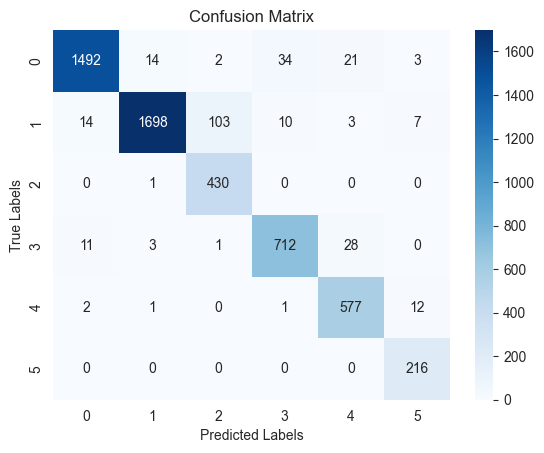

In [37]:
accuracy = accuracy_score(test_dataset.labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_dataset.labels, pred_labels, average='macro')
conf_mat = confusion_matrix(test_dataset.labels, pred_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', xticklabels=int_to_emotions.values(),
            yticklabels=int_to_emotions.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

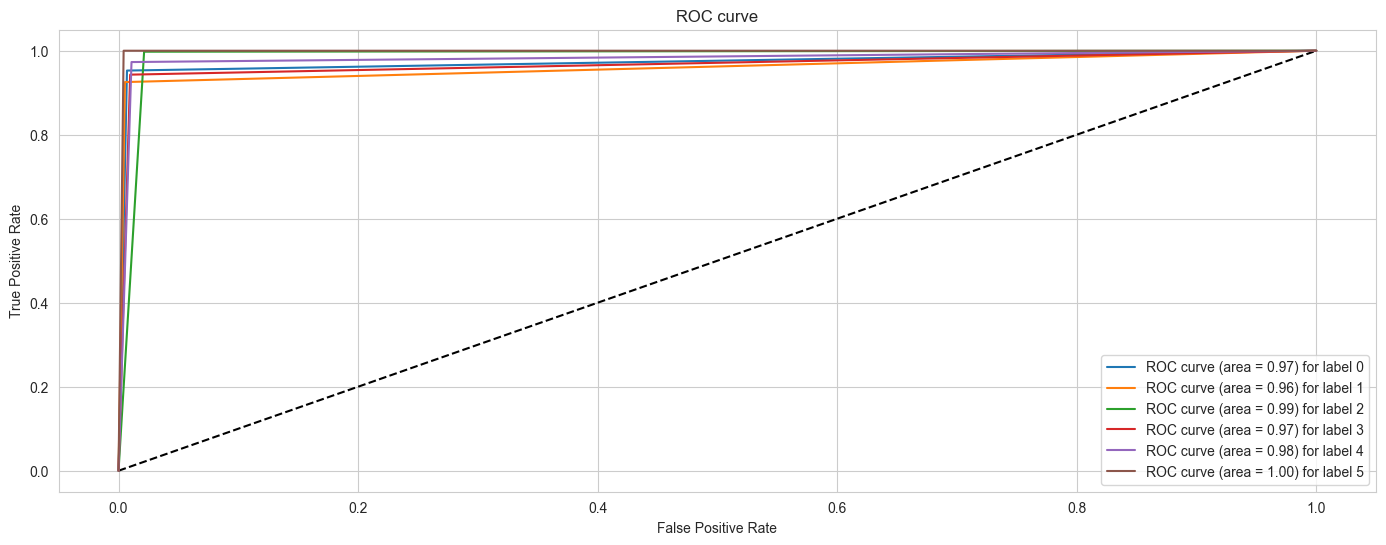

In [36]:
from sklearn.metrics import auc


def plot_multiclass_roc(y_pred, y_test, n_classes, figsize=(17, 6)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = np.eye(n_classes)[y_test]
    y_pred = np.eye(n_classes)[y_pred]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=figsize)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="best")
    plt.show()
    
plot_multiclass_roc(pred_labels, test_dataset.labels, n_classes=6)
    
    

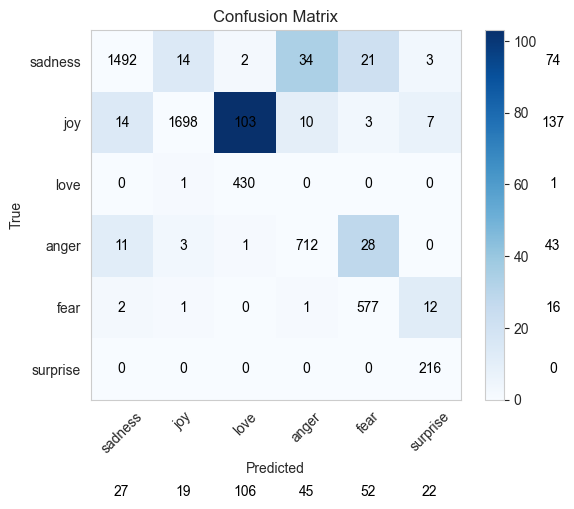

In [41]:

plt.clf()
conf_matrix = confusion_matrix(test_dataset.labels, pred_labels)
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
    
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
# remove plot grid
plt.grid(False)
# annotate the axes with the emotion names
plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
# add colorbar more to the right
plt.colorbar()
# legend the axes with predicted and true values
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, conf_matrix_copy[i, j], ha='center', va='center', color='black')
        else:
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

for i in range(conf_matrix.shape[0]): # this does not count correct predictions
    plt.text(7, i, conf_matrix[i, :].sum(), ha='center', va='center', color='black')
for i in range(conf_matrix.shape[1]):
    plt.text(i, 7, conf_matrix[:, i].sum(), ha='center', va='center', color='black')
plt.show()

## JOY classified as LOVE

In [ ]:
# Assuming test_dataset.labels contains the true labels
true_labels = np.array(test_dataset.labels)
p_labels = np.array(pred_labels.tolist())

In [ ]:
# Find indices where true label is 1 and predicted label is 2
indices = np.where((true_labels == 1) & (p_labels == 2))

In [61]:
# Get the elements from the dataset
[orig_test_data['text'][i] for i in indices[0]]

['struggling awful feelings saying sweet things not deserving sisters friendship agreed car just starting drive away reached hand',
 'write m sipping martini probably m feeling generous',
 'really liked feeling beloved liked except hes away missed',
 'feel blessed surrounded great coaches players administrators worked relentlessly dedicated institution',
 'tend mouth shut im not enough informed but comes public education speak feel thats topic im passionate best',
 'believed love lives feelings kind generous accepting exist independently decide not',
 'didnt know but went home later experiment feel accepted but experimented learned new feeling feeling greed',
 'love grapefruit macaron portrait feel gives feeing sweet but terrible taste like grapefruit just like macaron just looks like pretty cookie but complex',
 'say catholics immediately scouting feeling wont long harder accepted scouting openly catholic openly gay',
 'thankful people inner circle friends family mean world feel bless

## JOY classified as SADNESS

In [62]:
indices = np.where((true_labels == 1) & (p_labels == 0))

In [66]:
[orig_test_data['text'][i] for i in indices[0]]

['i feel that al gore is sincere in his beliefs but he is wasting his time',
 'i wasnt feeling very well so i just stood aside amp let people fall',
 'i know when you think of the name buck you think of a biker who has urine on his pants or your fishing buddy who doesn t say to much but that s because he is secretly smarter than you and he doesn t want you to feel like a moron by saying something intelligent',
 'i used to feel super lonely when he was away',
 'i respect the principle of her choice i cant help but feel betrayed by the seemingly casual disregard for my say in the matter',
 'i repeat i dint scribble this to hurt anyones feelings if it looks so my sincere apologies for that dont take it personally if you hate it',
 'id hurt someones feeling and it hurts me as well',
 'i still look at their actions and feel badly about how well ive raised them',
 'i feel grumpy a href http thegospelcoalition',
 'im not certain why but being up so late when most of the city is quiet and slee